## Project : House prices prediction

### (1) 데이터 불러오기

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
project_path = '/content/drive/MyDrive/Code/[E-03]/kaggle-kakr-housing-data/data'
training_path = join(project_path, 'train.csv')
test_path = join(project_path, 'test.csv')

In [ ]:
import pandas as pd
train = pd.read_csv(training_path)
test = pd.read_csv(test_path)
print('train: ', train.shape)
print('test:', test.shape)





train:  (15035, 21)
test: (6468, 20)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 데이터 살펴보기

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

'id'컬럼은 제외합니다
'date' 컬럼은 object 형으로 저장되어 있으므로, 자료변환합니다.

In [ ]:
# 결측치 확인
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

결측치는 없습니다. 

In [ ]:
# 중복 데이터 확인
train.duplicated().sum()

0

중복데이터도 없습니다.

##### feature 확인

kaggle에서 제공된 데이터셋을 사용하였습니다. 

https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr/data

##### Data fields

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


* Grade(King County Grading System)

* FLOAT형 자료형 : bathrooms, floors, lat, long
* OBJECT형 자료형 : date
* Target : price

In [ ]:
train.dtypes.value_counts()

int64      15
float64     5
object      1
dtype: int64

In [ ]:
# int, float, object 자료형별로 feature를 구분합니다.
col_int = [train.dtypes.index[i] for i in range(len(train.dtypes)) if train.dtypes[i] == 'int64']
col_float = [train.dtypes.index[i] for i in range(len(train.dtypes)) if train.dtypes[i] == 'float64' and train.dtypes.index[i] != 'price']
col_object = [train.dtypes.index[i] for i in range(len(train.dtypes)) if train.dtypes[i] == 'object']

target = 'price'

print('col_int : ', col_int)
print('col_float : ', col_float)
print('col_object : ', col_object)

col_int :  ['id', 'bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15']
col_float :  ['bathrooms', 'floors', 'lat', 'long']
col_object :  ['date']


In [ ]:
# 변수간의 correlations를 파악합니다.
train.corr().style.background_gradient(cmap='YlGn')


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


상관계수가 높은 경우

* sqft_living , sqft_above
* sqft_living, grade
* sqft_living, sqft_living15
* sqft_living, bathrooms

In [ ]:
# target column

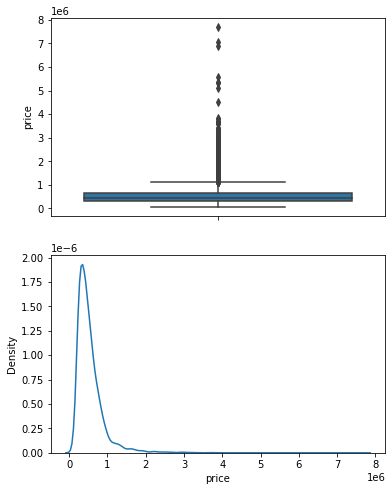

In [ ]:
price = train[target]
fig = plt.figure(figsize = (6, 8))
ax = fig.add_subplot(2,1,1)
sns.boxplot(y=price)

ax1 = fig.add_subplot(2,1,2)
sns.kdeplot(x=price)

plt.show()

결과값이 한쪽으로 치우쳐있습니다. 

정규분포와 가까운 모형을 만들기 위해 로그 스케일링을 합니다.

boxplot에서 이상치가 있어서 제거해주도록 하겠습니다.

In [ ]:
# 이상치 제거
train[train['price'] < 6000000]
train = train[train['price'] < 6000000]

#### int 64 column
---

In [ ]:
def graph_hist_scatter(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.histplot(data=dataset, x=feature)
    plt.title(f'{feature} hist')
    plt.xlabel('')

    ax = fig.add_subplot(1,2,2)
    sns.regplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel('')
    plt.show()

In [ ]:
# countplot & scatter
def graph_count_scatter(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.countplot(data=dataset, x=feature)
    plt.title(f'{feature} count')
    plt.xlabel('')

    ax = fig.add_subplot(1,2,2)
    sns.regplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel('')
    plt.show()

In [ ]:
def graph_count_box(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.countplot(data=dataset, x=feature)
    plt.title(f'{feature} count')
    plt.xlabel('')

    ax = fig.add_subplot(1,2,2)
    sns.boxplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel('')
    plt.show()

In [ ]:
def graph_hist_box(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.histplot(data=dataset, x=feature)
    plt.title(f'{feature} hist')

    ax = fig.add_subplot(1,2,2)
    sns.boxplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.show()

#### Bedrooms

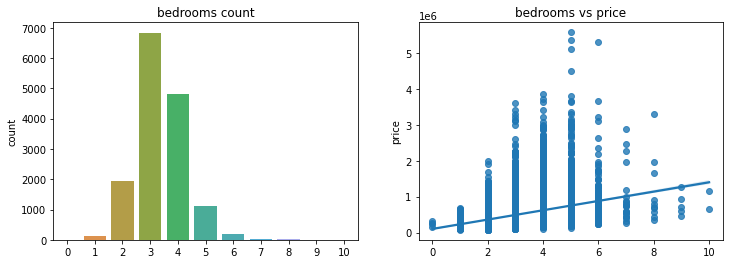

In [ ]:
graph_count_scatter(train, 'bedrooms', 'price')

2개 이상인 집들이 가격이 높습니다. 침실 개수 만으로는 가격을 맞추기 어려울 것 같습니다

#### sqft-living vs sqft_above vs sqft_basement

In [ ]:
# sqft_living - sqft_above = sqft_basement
train[['sqft_living15', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_lot', 'sqft_lot15']]

,sqft_living15,sqft_living,sqft_above,sqft_basement,sqft_lot,sqft_lot15
0,1340,1180,1180,0,5650,5650
1,2720,770,770,0,10000,8062
2,1800,1680,1680,0,8080,7503
3,2238,1715,1715,0,6819,6819
4,1650,1060,1060,0,9711,9711
...,...,...,...,...,...,...
15030,2520,2520,2520,0,6023,6023
15031,2050,3510,2600,910,7200,6200
15032,1530,1530,1530,0,1131,1509
15033,1830,2310,2310,0,5813,7200


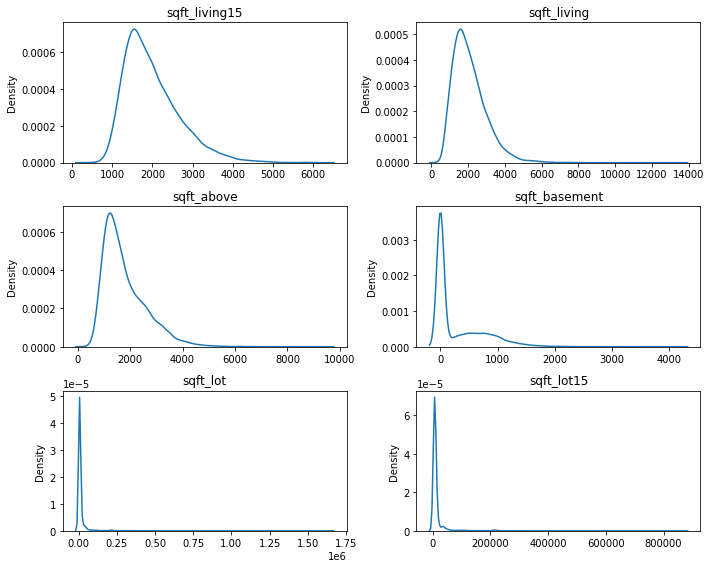

In [ ]:
sqft = ['sqft_living15','sqft_living','sqft_above','sqft_basement','sqft_lot','sqft_lot15']

fig = plt.figure(figsize = (10,8))
for i, col in enumerate(sqft) : 
    ax = fig.add_subplot(3, 2, i+1)
    sns.kdeplot(data=train, x=col)
    plt.xlabel('')
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
# 왜도 계산
from scipy.stats import skew

In [ ]:
for i in sqft : print(f'Skewness of {i} : {skew(train[i])}')

Skewness of sqft_living15 : 1.1245791992721614
Skewness of sqft_living : 1.3662992910648408
Skewness of sqft_above : 1.3586428334669851
Skewness of sqft_basement : 1.5383473836638848
Skewness of sqft_lot : 13.348714594309834
Skewness of sqft_lot15 : 10.027990160682432


모든 feature의 값이 1이 넘으므로 로그스케일링을 진행합니다.

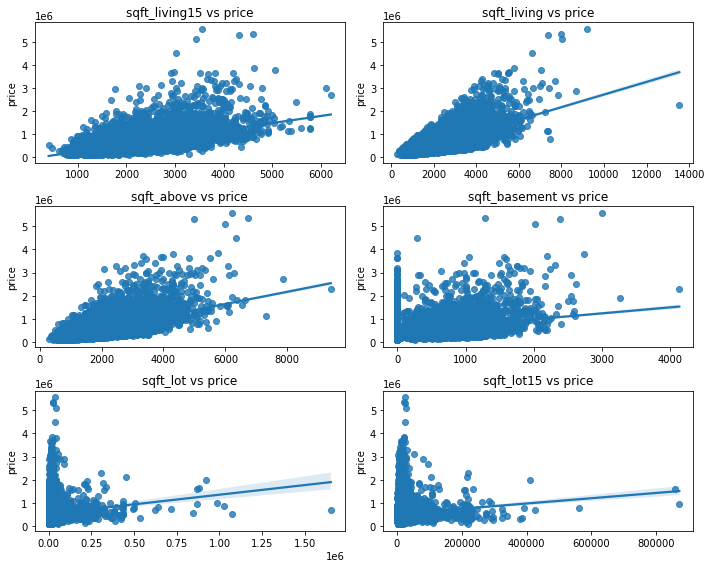

In [ ]:
fig = plt.figure(figsize = (10, 8))
for i, col in enumerate(sqft):
    ax = fig.add_subplot(3, 2, i+1)
    sns.regplot(data=train, x=col, y='price')
    plt.xlabel('')
    plt.title(f"{col} vs price")
    
plt.tight_layout()
plt.show()

평수가 커질수록 가격이 올라갔습니다. 주차 평수나 지하평수로는 예측이 어려워 보입니다


#### waterfront

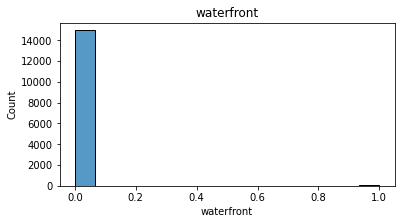

In [ ]:
fig = plt.figure(figsize=(6, 3))
sns.histplot(train['waterfront'])
plt.title('waterfront')
plt.show()

가격 예측에 waterfront는 도움이 되지 않습니다. 

#### view

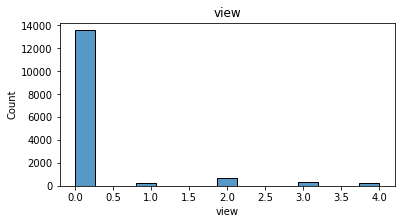

In [ ]:
fig = plt.figure(figsize=(6,3))
sns.histplot(train['view'])
plt.title('view')
plt.show()

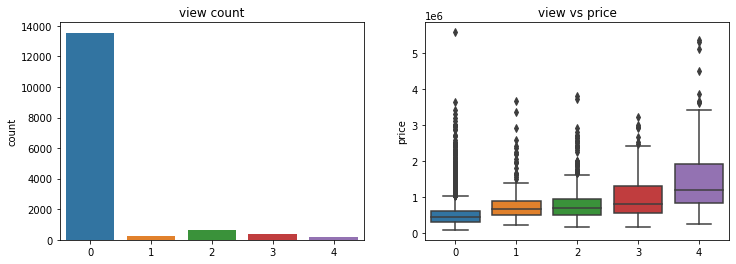

In [40]:
graph_count_box(train, 'view', 'price')

view가 좋아질수록 price도 높아지는 것을 볼 수 있습니다.

#### grade

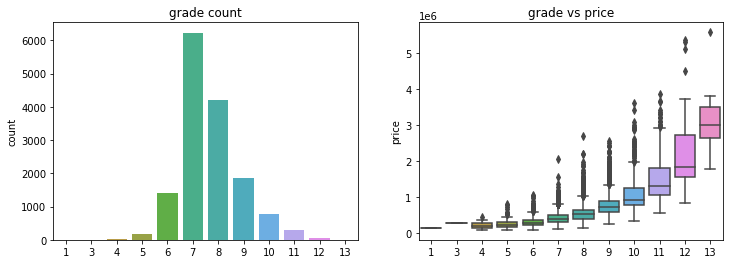

In [41]:
graph_count_box(train, 'grade', 'price')

grade 가 좋아질수록 price 가 높아지는 것을 볼 수 있습니다.

#### yr_built , yr_renovated

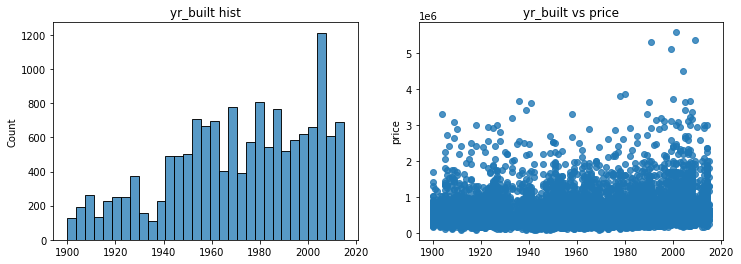

In [42]:
graph_hist_scatter(train, 'yr_built', 'price')

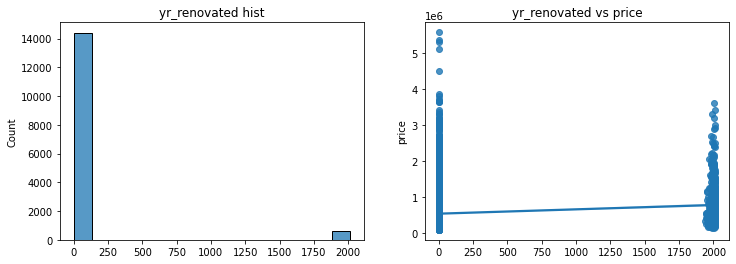

In [43]:
graph_hist_scatter(train, 'yr_renovated', 'price')

yr_built와 yr_renovated는 price에 별 영향을 미치는 것 같지 않습니다.

#### zipcode

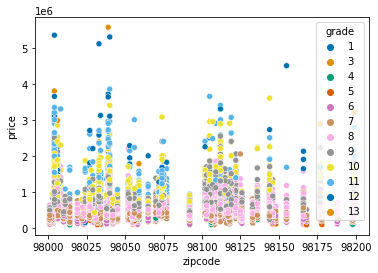

In [44]:
sns.scatterplot(data=train, y='price', x='zipcode', hue='grade', palette='colorblind')
plt.show()

우편번호와 가격의 연관성은 없어보이나 98000~08025 사이에 높은 가격의 집들이 많이 분포하고 있습니다.

#### float64 colum
---

#### bathrooms

In [45]:
train['bathrooms'].value_counts().sort_index()

0.00       4
0.50       3
0.75      45
1.00    2675
1.25       5
1.50    1009
1.75    2112
2.00    1357
2.25    1433
2.50    3748
2.75     843
3.00     493
3.25     410
3.50     510
3.75     108
4.00     100
4.25      57
4.50      63
4.75      16
5.00      14
5.25      11
5.50       7
5.75       3
6.00       2
6.25       1
6.75       1
7.50       1
8.00       1
Name: bathrooms, dtype: int64

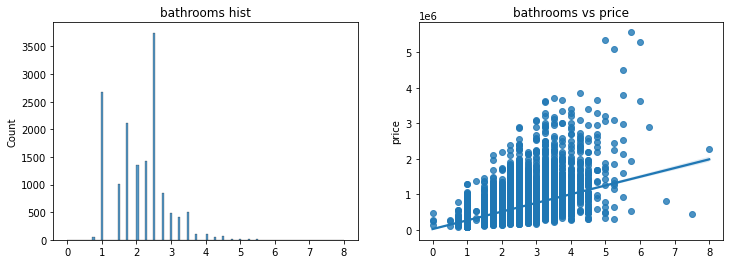

In [46]:
graph_hist_scatter(train, 'bathrooms', 'price')

화장실이 많아질수록 가격이 올라갑니다.

#### floor

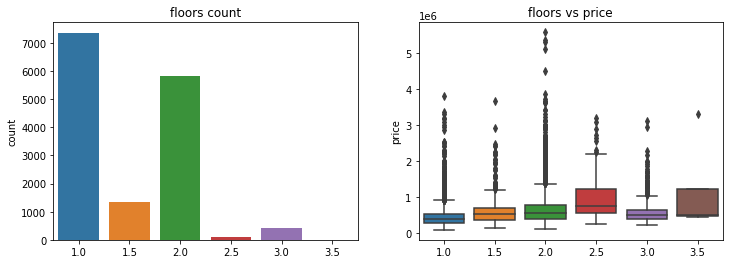

In [47]:
graph_count_box(train, 'floors', 'price')

2.5층과 3.5층이 가격이 높은 것을 볼 수 있습니다.

#### lat, long

In [48]:
# 집 가격을 5개 구간으로 나누어서 hue를 설정합니다.

In [49]:
train['pricerange'] = pd.qcut(x = train['price'], q = 5, labels=[1, 2, 3, 4, 5])

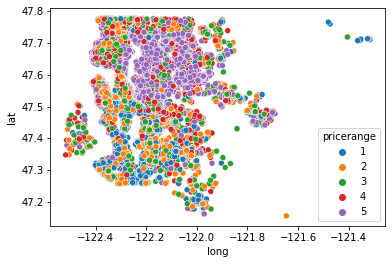

In [50]:
sns.scatterplot(data=train, x='long', y='lat', hue='pricerange')
plt.show()

주로 보라색으로 표시된 부분을 중심으로 비싼 집들이 군집하여 있습니다. 주요도시와의 거리를 계산해서 새로운 feature로 추가하겠습니다. 

In [51]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from haversine import haversine, Unit

In [53]:
seattle = [46.6092, -122.3363]
bellevue = [47.61555, -122.20392]

In [54]:
haversine(seattle, bellevue,unit=Unit.MILES)

69.8102115661099

In [56]:
#train
train['coordinates'] = list(zip(train['lat'],train['long']))
train['seattle_dist'] = train['coordinates'].apply(lambda x: haversine(x,seattle,unit =Unit.MILES))
train['bellevue_dist'] = train['coordinates'].apply(lambda x: haversine(x,bellevue,unit =Unit.MILES))

#test
test['coordinates'] = list(zip(test['lat'],test['long']))
test['seattle_dist'] = test['coordinates'].apply(lambda x: haversine(x,seattle,unit =Unit.MILES))
test['bellevue_dist'] = test['coordinates'].apply(lambda x: haversine(x,bellevue,unit =Unit.MILES))

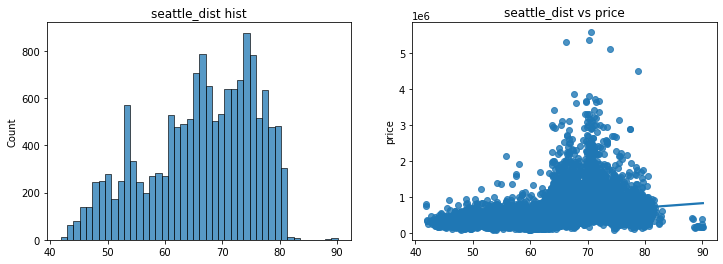

In [57]:
graph_hist_scatter(train, 'seattle_dist', 'price')

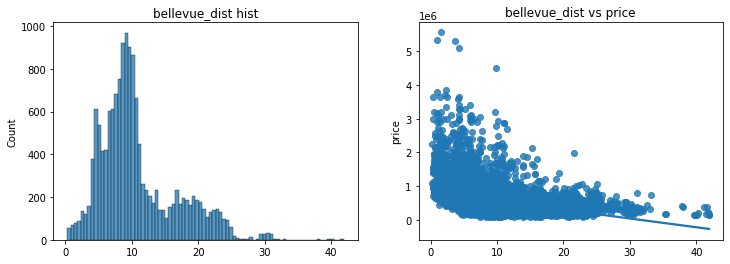

In [58]:
graph_hist_scatter(train, 'bellevue_dist', 'price')

In [59]:
train[['price','seattle_dist','bellevue_dist','lat','long']].corr().style.background_gradient(cmap='YlGn')

,price,seattle_dist,bellevue_dist,lat,long
price,1.000000,0.310942,-0.417332,0.309819,0.025594
seattle_dist,0.310942,1.000000,-0.665851,0.994206,-0.039761
bellevue_dist,-0.417332,-0.665851,1.000000,-0.703235,0.245347
lat,0.309819,0.994206,-0.703235,1.000000,-0.133435
long,0.025594,-0.039761,0.245347,-0.133435,1.000000


Settle과 거리가 중간정도 되는 집들이 집값이 높고, Bellvue와 거리가 가까울 수록 가격이 높아집니다.

In [61]:
# 다른 18개 지역도 추가
ballard = (47.682061, -122.393882)
lakecity =(47.723538, -122.286637)
wedgewood = (47.689600, -122.295537)
wu = (47.656250, -122.311010)
wf =(47.656627, -122.339032)
lp = (47.652656, -122.397650)
sn =(47.614038, -122.347546)
ch =(47.621543, -122.317746)
wp =(47.626178, -122.288273)
square = (47.600188, -122.332234)
norhtadmiral = (47.576393, -122.390178)
roxhill = (47.522859, -122.374381)
georgetown =(47.550410, -122.328636)
kubota = (47.516414, -122.272688)
colombia = (47.555963, -122.275979)
sodo =(47.585051, -122.330610)
cdis =(47.605163, -122.297362)
madrona =(47.616688, -122.293445)
walling =(47.668264, -122.329730)

In [62]:
points =[ballard, lakecity, wedgewood, wu, wf, lp, sn, ch, wp, square, norhtadmiral, roxhill, georgetown, kubota, colombia, sodo, cdis, madrona, walling]
points[8]

(47.626178, -122.288273)

In [63]:
len(points)

19

In [64]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters = 19, init = points, n_init=1, random_state=2022)
clusterdata = train.loc[:,['lat', 'long']].values
kmean.fit(clusterdata)
kmean.labels_
train['region'] = kmean.labels_
clusterdata_test = test.loc[:,['lat', 'long']].values
kmean.fit_transform(clusterdata_test)
test['region'] =  kmean.labels_

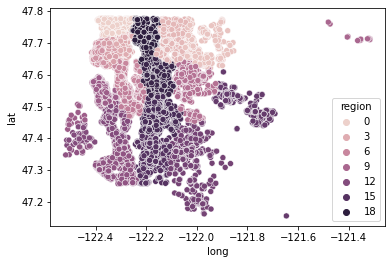

In [66]:
sns.scatterplot(data= train,x='long',y ='lat', hue='region')
plt.show()

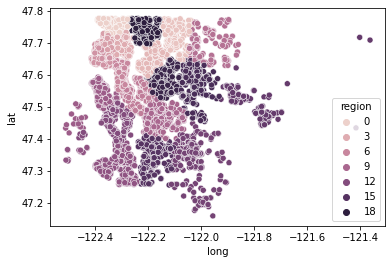

In [67]:
sns.scatterplot(data= test,x='long',y ='lat', hue='region')
plt.show()

지역별로 군집해서 분류한 데이터로 가격과의 관계를 봤을때 퍼져있는 것을 볼 수 있습니다.

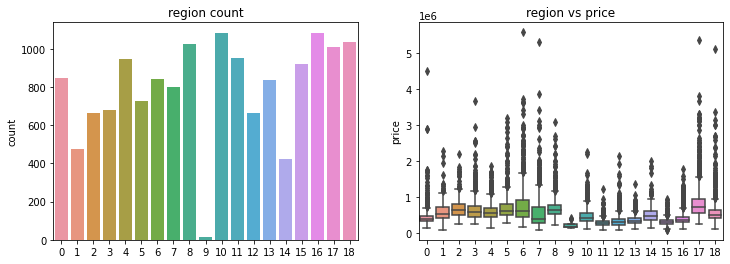

In [68]:
graph_count_box(train, 'region', 'price')

In [69]:
train['region'].value_counts()

10    1084
16    1081
18    1037
8     1024
17    1010
11     951
4      949
15     921
0      849
6      842
13     835
7      801
5      729
3      680
12     665
2      664
1      473
14     423
9       14
Name: region, dtype: int64

In [71]:
# 위 지역 8개와 centroid와의 거리 계산
mapping = {0 : (47.682061, -122.393882),
1 : (47.723538, -122.286637),
2 : (47.689600, -122.295537),
3 : (47.656250, -122.311010),
4 : (47.656627, -122.339032),
5 : (47.652656, -122.397650),
6 : (47.614038, -122.347546),
7 : (47.621543, -122.317746),
8 : (47.626178, -122.288273),
9 : (47.600188, -122.332234),
10 : (47.576393, -122.390178),
11 : (47.522859, -122.374381),
12 : (47.550410, -122.328636),
13 : (47.516414, -122.272688),
14 : (47.555963, -122.275979),
15 : (47.585051, -122.330610),
16 : (47.605163, -122.297362),
17 : (47.616688, -122.293445),
18 : (47.668264, -122.329730)}

for data in [train, test] :
    data['centroid'] = data['region'].apply(lambda x : mapping[x])
    data['centroid_dist'] = data.apply(lambda x : haversine(x['centroid'],x['coordinates'],unit =Unit.MILES),axis=1)
    data['centroid_dist']

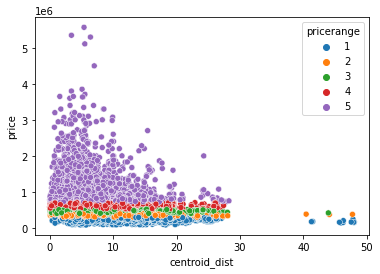

In [72]:
sns.scatterplot(data=train, x='centroid_dist', y='price', hue='pricerange')
plt.show()

centroid와 거리가 가까울수록 가격이 높아집니다.

#### date feature

In [73]:
## object자료형에서 숫자로 바꾸어줍니다.
train['date'].describe()

count               15032
unique                365
top       20140623T000000
freq                  101
Name: date, dtype: object

In [74]:
# train
train['date'] = train['date'].apply(lambda x : x[:8]).astype(int)

# test
test['date'] = test['date'].apply(lambda x : x[:8]).astype(int)

In [75]:
train['date'].describe()

count    1.503200e+04
mean     2.014387e+07
std      4.425365e+03
min      2.014050e+07
25%      2.014072e+07
50%      2.014102e+07
75%      2.015021e+07
max      2.015051e+07
Name: date, dtype: float64

### (3) Feature Engineering

In [77]:
#train
train['floor_area_ratio'] = train['sqft_living'] / train['sqft_lot']
train['rooms'] = train['bedrooms'] + train['bathrooms']
train['grade_condition'] = train['grade'] * train['condition']
train['sqft_total_size'] = train['sqft_above'] + train['sqft_basement']

#test
test['floor_area_ratio'] = test['sqft_living'] / test['sqft_lot']
test['rooms'] = test['bedrooms'] + test['bathrooms']
test['grade_condition'] = test['grade'] * test['condition']
test['sqft_total_size'] = test['sqft_above'] + test['sqft_basement']

# source : https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12

In [78]:
for df in [train, test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [79]:
# one-hot encoding
train = pd.get_dummies(train, columns = ['region'])
test = pd.get_dummies(test, columns = ['region'])

In [80]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'pricerange',
       'coordinates', 'seattle_dist', 'bellevue_dist', 'centroid',
       'centroid_dist', 'floor_area_ratio', 'rooms', 'grade_condition',
       'sqft_total_size', 'region_0', 'region_1', 'region_2', 'region_3',
       'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9',
       'region_10', 'region_11', 'region_12', 'region_13', 'region_14',
       'region_15', 'region_16', 'region_17', 'region_18'],
      dtype='object')

In [81]:
set(train.columns)- set(test.columns)

{'price', 'pricerange'}

In [82]:
removing_feature = ['id', 'coordinates', 'centroid','price','pricerange'] #'lat','long','sqft_living15','sqft_above',

removing_feature.extend(['sqft_living', 'region_9','region_18', 'region_1', 'region_11', 'region_13', 'region_17', 'region_14'])

In [84]:
selected_feature = list( set(train.columns) - set(removing_feature))

In [85]:
for i in sqft:
  train[i] = train[i].apply(lambda x :np.log1p(x))
  test[i] = test[i].apply(lambda x : np.log1p(x))

In [86]:
X_train = train[selected_feature].values
y_train = train['price'].apply(lambda x : np.log1p(x))
X_test = test[selected_feature].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(15032, 37)
(15032,)
(6468, 37)


In [87]:
# Feature Scaling
from sklearn.preprocessing import RobustScaler

In [88]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

#### (4) Train Validation Split

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=2022)

#### (5) Model Baseline

In [91]:
# import Model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifierCV

from sklearn.metrics import mean_squared_error

In [92]:
model = LGBMRegressor(random_state=2022)

def get_score_prediction(model, x, y, test, true):
  model.fit(x, y)
  pred = model.predict(test)
  print("RMSE : ", mean_squared_error(np.expm1(true), np.expm1(pred)) ** 0.5)
  return np.expm1(pred)

get_score_prediction(model, X_t, y_t, X_v, y_v)

RMSE :  107141.52984828921


array([831983.34844467, 514027.38774424, 184030.16612853, ...,
       668242.56447993, 520834.69906041, 211582.95445378])

### (6) Tuning

In [93]:
from sklearn.model_selection import cross_val_score

lgb = LGBMRegressor(random_state=2022)

##### Hyper Parameter Tuning

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
from tqdm import tqdm
import time

def myGrid(model, param,x, y):
    start = time.time()
    mygrid = GridSearchCV(model, param_grid = param, scoring = 'neg_mean_squared_error', n_jobs=5, verbose=1)
    mygrid.fit(x,y)
    params= mygrid.cv_results_['params']
    score= mygrid.cv_results_['mean_test_score']
    for i in tqdm(range(len(params))):
        params[i]['score'] = score[i]
    
    print(f'(time lapsed : {time.time() - start} sec.)')
    return pd.DataFrame(params).sort_values(by='score', ascending=False)

In [97]:
param_grid = {'max_depth' : [-1,15,32], 'n_estimators' : [100,1100,3100], 
              'num_leaves':[43,50,112],'learning_rate': [0.1, 0.015]}

In [100]:
param_grid = {'max_depth' : 15, 'n_estimators' : 1100, 
              'num_leaves': 43,'learning_rate': 0.015}
lgb = LGBMRegressor(random_state=2022, objective= 'regression', **param_grid)
p1 = get_score_prediction(lgb, X_t, y_t,X_v, y_v)

RMSE :  105710.10615679114


In [107]:
lgb.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.015, max_depth=15, n_estimators=1100,
              num_leaves=43, objective='regression', random_state=2022)

In [108]:
sub_id = test.id
sub_id.shape

(6468,)

In [112]:
def make_submission(model,test) :
    prediction = np.expm1(model.predict(test))
    sub = pd.DataFrame({'id':sub_id, 'price':prediction})
    sub.to_csv(f'/content/drive/MyDrive/Code/[E-03]submission_{model.__class__.__name__}.csv', index=False)

In [113]:
make_submission(lgb, X_test)